In [128]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import lightgbm as ltb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from category_encoders import TargetEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [129]:
df = pd.read_csv("train.csv")

# ##Clean the data and make it readable


In [130]:
df.describe()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
count,50882.000000,50882.000000,50882.000000,50882.000000,30631.000000,50882.000000,50882.000000,50882.000000
mean,25441.500000,1732.788707,44.856275,42.738866,2.439228,15.115188,14183.950069,0.239947
std,14688.512535,1424.081652,17.310271,17.319375,1.025923,6.340663,6590.074873,0.427055
min,1.000000,1.000000,18.000000,16.000000,1.000000,1.000000,2280.000000,0.000000
25%,12721.250000,523.000000,28.000000,27.000000,1.000000,12.000000,9248.000000,0.000000
50%,25441.500000,1391.000000,44.000000,40.000000,3.000000,17.000000,13178.000000,0.000000
75%,38161.750000,2667.000000,59.000000,57.000000,3.000000,20.000000,18096.000000,0.000000
max,50882.000000,6194.000000,75.000000,75.000000,4.000000,22.000000,43350.400000,1.000000


In [132]:
df.dtypes

ID                           int64
City_Code                   object
Region_Code                  int64
Accomodation_Type           object
Reco_Insurance_Type         object
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type        float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                     int64
dtype: object

# Checking distribution of reco premium . Right skewed.Need to transform it.

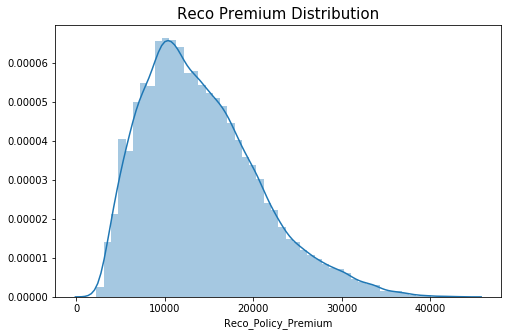

In [133]:

plt.figure(figsize = (8, 5))
sns.distplot(df['Reco_Policy_Premium'])
plt.title('Reco Premium Distribution', fontsize = 15)
plt.show()

In [134]:
df['Reco_Policy_Premium'] = df['Reco_Policy_Premium']**(1/5)

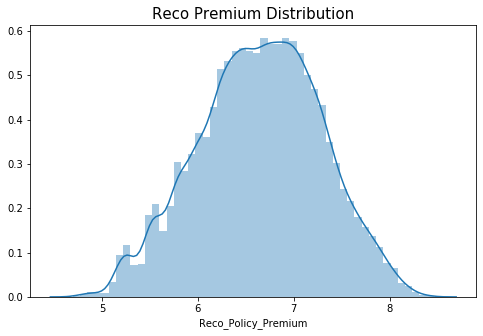

In [135]:

plt.figure(figsize = (8, 5))
sns.distplot(df['Reco_Policy_Premium'])
plt.title('Reco Premium Distribution', fontsize = 15)
plt.show()

In [136]:
df.columns = df.columns.str.replace(' ', '_') 

In [137]:
df['City_Code'] = df['City_Code'].str[0:1]+'_'+df['City_Code'].str[1:]

In [138]:
df['Health_Indicator'] = 'I'+ df['Health_Indicator'].str[1:]

In [139]:
df

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C_3,3213,Rented,Individual,36,36,No,I1,14+,3.0,22,6.502809,0
1,2,C_5,1117,Owned,Joint,75,22,No,I2,NaN,NaN,22,7.886575,0
2,3,C_5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,5.948826,1
3,4,C_24,4378,Owned,Joint,52,48,No,I1,14+,3.0,19,7.079235,0
4,5,C_8,2190,Rented,Individual,44,44,No,I2,3.0,1.0,16,6.359750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,50878,C_4,845,Rented,Individual,22,22,No,I3,NaN,NaN,18,5.988848,0
50878,50879,C_5,4188,Rented,Individual,27,27,No,I3,7.0,3.0,4,5.579655,0
50879,50880,C_1,442,Rented,Individual,63,63,No,I2,14+,1.0,12,6.474148,0
50880,50881,C_1,4,Owned,Joint,71,49,No,I2,2.0,2.0,16,7.762216,1


# Dealing with missing data

In [140]:
df['Holding_Policy_Duration']=df['Holding_Policy_Duration'].replace('14+','20.0')
median_data_hpd = df['Holding_Policy_Duration'].median(skipna=True)
mode_data_hi = df['Health_Indicator'].mode()[0]



# Encoding categorical variables

In [141]:
def hpd(df):
    
    df['Holding_Policy_Duration']=df['Holding_Policy_Duration'].replace('14+','20.0')
    df['Holding_Policy_Duration'].fillna('0.0', inplace=True)
    df['Holding_Policy_Duration'] = pd.to_numeric(df['Holding_Policy_Duration'])
    df['Holding_Policy_Duration'] = df.Holding_Policy_Duration.round(0).astype(int)
    #df['Holding_Policy_Duration']=df['Holding_Policy_Duration'].replace(0,median_data_hpd)




In [142]:
def healthindicator(df):
    df['Health_Indicator'].fillna(mode_data_hi, inplace=True)
    #print(df['Health Indicator'].head())
    fe = df.groupby('Health_Indicator').size()/len(df)
    df['Health_Indicator']=df['Health_Indicator'].map(fe)
    #number = LabelEncoder()
    #df['Health Indicator']=number.fit_transform(df['Health Indicator'].astype('str'))
    

In [143]:
def citycode(df):
    fe = df.groupby('City_Code').size()/len(df)
    df['City_Code']=df['City_Code'].map(fe)
    

In [144]:
def regioncode(df):
    fe = df.groupby('Region_Code').size()/len(df)
    df['Region_Code']=df['Region_Code'].map(fe)
    


In [145]:
df

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C_3,3213,Rented,Individual,36,36,No,I1,20.0,3.0,22,6.502809,0
1,2,C_5,1117,Owned,Joint,75,22,No,I2,NaN,NaN,22,7.886575,0
2,3,C_5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,5.948826,1
3,4,C_24,4378,Owned,Joint,52,48,No,I1,20.0,3.0,19,7.079235,0
4,5,C_8,2190,Rented,Individual,44,44,No,I2,3.0,1.0,16,6.359750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,50878,C_4,845,Rented,Individual,22,22,No,I3,NaN,NaN,18,5.988848,0
50878,50879,C_5,4188,Rented,Individual,27,27,No,I3,7.0,3.0,4,5.579655,0
50879,50880,C_1,442,Rented,Individual,63,63,No,I2,20.0,1.0,12,6.474148,0
50880,50881,C_1,4,Owned,Joint,71,49,No,I2,2.0,2.0,16,7.762216,1


In [146]:
def hpt(df):
    df['Holding_Policy_Type']=df['Holding_Policy_Type'].replace(np.nan, 0)
    df['Holding_Policy_Type'] = df.Holding_Policy_Type.round(0).astype(int)
    number = LabelEncoder()
    df['Holding_Policy_Type']=number.fit_transform(df['Holding_Policy_Type'].astype('str'))
    

In [147]:
def recopolicycat(df):
    #encoder = TargetEncoder()
    #df['Reco_Policy_Cat'] = df['Reco_Policy_Cat'].astype('str')
    #df['Reco_Policy_Cat']=encoder.fit_transform(df['Reco_Policy_Cat'],df['Response'])
    fe = df.groupby('Region_Code').size()/len(df)
    df['Region_Code']=df['Region_Code'].map(fe)

In [148]:
#def encodeObjTypeFeatures(df):
    #encoder = TargetEncoder()
    #df['Accomodation_Type']=encoder.fit_transform(df['Accomodation_Type'],df['Response'])
    #encoder = TargetEncoder()
    #df['Reco_Insurance_Type']=encoder.fit_transform(df['Reco_Insurance_Type'],df['Response'])
    #encoder = TargetEncoder()
    #df['Is_Spouse']=encoder.fit_transform(df['Is_Spouse'],df['Response'])
    #encoder = TargetEncoder()
    #df['Holding_Policy_Type']=encoder.fit_transform(df['Holding_Policy_Type'],df['Response'])
    #encoder = LabelEncoder()
    #df['City_Code']=encoder.fit_transform(df['City_Code'])
   
    #fe = df.groupby('City_Code').size()/len(df)
    #df['City_Code']=df['City_Code'].map(fe)
    #number = LabelEncoder()
    #df['Health Indicator']=number.fit_transform(df['Health Indicator'].astype('str'))


# Creating new features

In [149]:
def formNewUpperAgeFeature(df):
    df["bin_upper_age"]=""
    df.loc[(df["Upper_Age"]>=16) & (df["Upper_Age"]<26),"bin_upper_age"]="Young"
    df.loc[(df["Upper_Age"]>=26) & (df["Upper_Age"]<45),"bin_upper_age"]="Adults"
    df.loc[(df["Upper_Age"]>=45) & (df["Upper_Age"]<80),"bin_upper_age"]="Senior Citizens"

    number = LabelEncoder()
    df['bin_upper_age']=number.fit_transform(df['bin_upper_age'].astype('str'))


In [150]:
def formNewLowerAgeFeature(df):
    df["bin_lower_age"]=""
    df.loc[(df["Lower_Age"]>=16) & (df["Lower_Age"]<26),"bin_lower_age"]="LowYoung"
    df.loc[(df["Lower_Age"]>=26) & (df["Lower_Age"]<45),"bin_lower_age"]="LowAdults"
    df.loc[(df["Lower_Age"]>=45) & (df["Lower_Age"]<80),"bin_lower_age"]="LowSeniorCitizens"

    number = LabelEncoder()
    df['bin_lower_age']=number.fit_transform(df['bin_lower_age'].astype('str'))


# Pre processing steps

In [152]:
##Preprocessing Steps
hpd(df)
#healthindicator(df)
hpt(df)
formNewUpperAgeFeature(df)
formNewLowerAgeFeature(df)
citycode(df)
recopolicycat(df)
df=pd.get_dummies(data=df, columns=['Accomodation_Type', 'Reco_Insurance_Type','Is_Spouse','Health_Indicator'])
regioncode(df)
#standardizePremium(df)






In [153]:
df

,ID,City_Code,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,...,Is_Spouse_Yes,Health_Indicator_I1,Health_Indicator_I2,Health_Indicator_I3,Health_Indicator_I4,Health_Indicator_I5,Health_Indicator_I6,Health_Indicator_I7,Health_Indicator_I8,Health_Indicator_I9
0,1,0.096085,0.043080,36,36,20,3,22,6.502809,0,...,0,1,0,0,0,0,0,0,0,0
1,2,0.026807,0.040427,75,22,0,0,22,7.886575,0,...,0,0,1,0,0,0,0,0,0,0
2,3,0.026807,0.040722,32,32,1,1,19,5.948826,1,...,0,0,0,0,0,0,0,0,0,0
3,4,0.010868,0.032231,52,48,20,3,19,7.079235,0,...,0,1,0,0,0,0,0,0,0,0
4,5,0.035494,0.049291,44,44,3,1,16,6.359750,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,50878,0.072147,0.038560,22,22,0,0,18,5.988848,0,...,0,0,0,1,0,0,0,0,0,0
50878,50879,0.026807,0.031013,27,27,7,3,4,5.579655,0,...,0,0,0,1,0,0,0,0,0,0
50879,50880,0.176349,0.025942,63,63,20,1,12,6.474148,0,...,0,0,1,0,0,0,0,0,0,0
50880,50881,0.176349,0.004304,71,49,2,2,16,7.762216,1,...,0,0,1,0,0,0,0,0,0,0


In [154]:
df

,ID,City_Code,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,...,Is_Spouse_Yes,Health_Indicator_I1,Health_Indicator_I2,Health_Indicator_I3,Health_Indicator_I4,Health_Indicator_I5,Health_Indicator_I6,Health_Indicator_I7,Health_Indicator_I8,Health_Indicator_I9
0,1,0.096085,0.043080,36,36,20,3,22,6.502809,0,...,0,1,0,0,0,0,0,0,0,0
1,2,0.026807,0.040427,75,22,0,0,22,7.886575,0,...,0,0,1,0,0,0,0,0,0,0
2,3,0.026807,0.040722,32,32,1,1,19,5.948826,1,...,0,0,0,0,0,0,0,0,0,0
3,4,0.010868,0.032231,52,48,20,3,19,7.079235,0,...,0,1,0,0,0,0,0,0,0,0
4,5,0.035494,0.049291,44,44,3,1,16,6.359750,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,50878,0.072147,0.038560,22,22,0,0,18,5.988848,0,...,0,0,0,1,0,0,0,0,0,0
50878,50879,0.026807,0.031013,27,27,7,3,4,5.579655,0,...,0,0,0,1,0,0,0,0,0,0
50879,50880,0.176349,0.025942,63,63,20,1,12,6.474148,0,...,0,0,1,0,0,0,0,0,0,0
50880,50881,0.176349,0.004304,71,49,2,2,16,7.762216,1,...,0,0,1,0,0,0,0,0,0,0


# Drop unnecessary columns before training model. Since new features have been created for upper and lower age, dropping original columns

In [155]:
df.drop(['ID','Lower_Age','Upper_Age'],axis=1,inplace=True)

In [156]:
df

,City_Code,Region_Code,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,bin_upper_age,bin_lower_age,Accomodation_Type_Owned,...,Is_Spouse_Yes,Health_Indicator_I1,Health_Indicator_I2,Health_Indicator_I3,Health_Indicator_I4,Health_Indicator_I5,Health_Indicator_I6,Health_Indicator_I7,Health_Indicator_I8,Health_Indicator_I9
0,0.096085,0.043080,20,3,22,6.502809,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.026807,0.040427,0,0,22,7.886575,0,1,2,1,...,0,0,1,0,0,0,0,0,0,0
2,0.026807,0.040722,1,1,19,5.948826,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.010868,0.032231,20,3,19,7.079235,0,1,1,1,...,0,1,0,0,0,0,0,0,0,0
4,0.035494,0.049291,3,1,16,6.359750,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,0.072147,0.038560,0,0,18,5.988848,0,2,2,0,...,0,0,0,1,0,0,0,0,0,0
50878,0.026807,0.031013,7,3,4,5.579655,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
50879,0.176349,0.025942,20,1,12,6.474148,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
50880,0.176349,0.004304,2,2,16,7.762216,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0


In [158]:
X = df.drop(['Response'],axis=1)
Y = df['Response']

# Model training

In [161]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier


model = LGBMClassifier()
#model = XGBClassifier()
     

cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=3)
n_scores = cross_val_score(model, X, Y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')

In [163]:
np.mean(n_scores)

0.6726590857719184

In [164]:
model.fit(X,Y)

LGBMClassifier()

# Visualization for checking effect of chosen features on response variable

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 <a list of 23 Text xticklabel objects>)

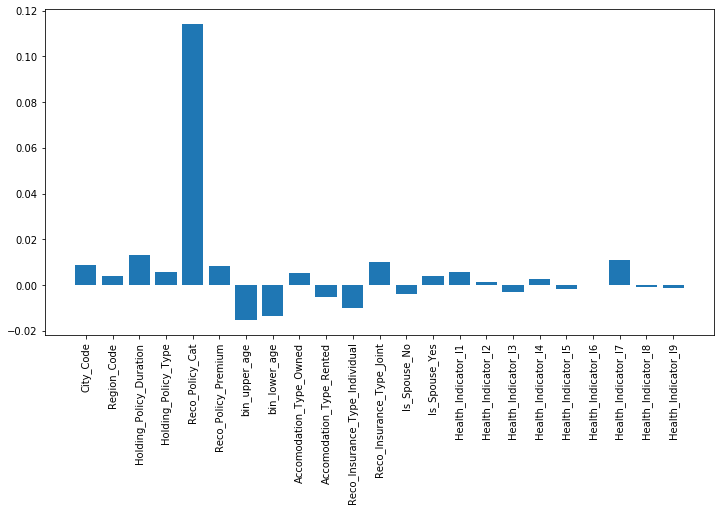

In [165]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

correlation_values = []
correlation_labels = X.columns

for col_idx in range(0,len(X.columns)):
    correlation = np.corrcoef(X.iloc[:,col_idx],Y)
    correlation_values.append(correlation[0][1])
    
ax1.bar(x=correlation_labels,height=correlation_values)
plt.xticks(rotation='vertical')

In [109]:

#from sklearn.model_selection import learning_curve

#train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X, Y, cv=5, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))


In [110]:
#train_mean = np.mean(train_scores, axis=1)
#train_std = np.std(train_scores, axis=1)

#test_mean = np.mean(test_scores, axis=1)
#test_std = np.std(test_scores, axis=1)

In [111]:
#import matplotlib.pyplot as plt
#plt.subplots(1, figsize=(10,10))
#plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
#plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

#plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
#plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

#plt.title("Learning Curve")
#plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
#plt.tight_layout()
#plt.show()

# Predicting for test data

In [166]:
data_test = pd.read_csv("test.csv")

In [167]:
data_test

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21800,72683,C3,1044,Owned,Individual,45,45,No,X1,4.0,1.0,18,15884.0
21801,72684,C4,266,Owned,Individual,59,59,No,X5,6.0,3.0,18,21390.0
21802,72685,C12,2470,Owned,Individual,74,74,No,X3,NaN,NaN,1,17836.0
21803,72686,C10,1676,Rented,Individual,25,25,No,X4,3.0,1.0,19,11568.0


In [168]:

data_test.columns = data_test.columns.str.replace(' ', '_')
data_test['City_Code'] = data_test['City_Code'].str[0:1]+'_'+data_test['City_Code'].str[1:]
data_test['Health_Indicator'] = 'I'+ data_test['Health_Indicator'].str[1:]
data_test['Reco_Policy_Premium'] = data_test['Reco_Policy_Premium']**(1/5)

In [169]:
hpd(data_test)
#healthindicator(data_test)
hpt(data_test)
formNewUpperAgeFeature(data_test)
formNewLowerAgeFeature(data_test)
citycode(data_test)
recopolicycat(data_test)
data_test=pd.get_dummies(data=data_test, columns=['Accomodation_Type', 'Reco_Insurance_Type','Is_Spouse','Health_Indicator'])
regioncode(data_test)

In [170]:
data_test.drop(['Lower_Age','Upper_Age'],axis=1,inplace=True)

In [171]:
X_new= data_test.drop(['ID'],axis=1)

In [173]:
filename = 'submission_best_model_{}.csv'
y_pred_final =model.predict_proba(X_new)[:, 1]
submission = pd.DataFrame(
    {'ID': data_test.ID, 'Response': y_pred_final},
    columns = ['ID', 'Response'])
submission.to_csv(filename, index = False)